<a href="https://colab.research.google.com/github/Rahim-Mitha55/23229574-Chess-repo/blob/main/Chess_comAPI_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Note: Search link between 2 or more variables
#1. Null Hypothesis: Choice of opening has no correlation on the probability of winning a game
Alternative Hypothesis: Choice of opening has a positive impact on the probability of winning a game

Alternative Hypothesis: Choice of opening has a negative impact on the probability of winning a game
#2. Null Hypothesis: There is no correlation in players having different draw rate in Blitz games than in Bullet games
Alternative Hypothesis: Players have a higher draw rate in Blitz games than in Bullet games

Alternative Hypothesis: Players have a lower draw rate in Blitz games than in Bullet games









In [ ]:
pip install chess.com

In [ ]:


#Import Libraries
import time       # Provides time-related functions, measuring execution time or creating delays
from scipy import stats  # Access to t-test, z-test, distributions
import seaborn as sns    # visualization library for creating attractive statistical plots
import requests   # For making requests to the Chess.com API
import pandas as pd      # For Dataframe handling
import numpy as np       # For numerical operations
import matplotlib.pyplot as plt  # For plotting results
from scipy.stats import ttest_ind  # For t-tests


HEADERS = {"User-Agent": "MyChessApp/1.0"}
MAX_PLAYERS_FETCH = 1000
REQUEST_DELAY = 0.3
def get_leaderboard_users(leaderboard_key):
    url = "https://api.chess.com/pub/leaderboards"
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    return [p['username'] for p in data.get(leaderboard_key, [])]
def get_titled_players(title):
    url = f"https://api.chess.com/pub/titled/{title}"
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    return data.get('players', [])
def fetch_player_stats(username):
    url = f"https://api.chess.com/pub/player/{username}/stats"
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    return resp.json()
usernames = set()
leaderboard_keys = ['live_blitz', 'live_bullet', 'daily_blitz', 'daily_bullet']
for key in leaderboard_keys:
    try:
        lb_users = get_leaderboard_users(key)
        usernames.update(lb_users)
        print(f"Added {len(lb_users)} usernames from leaderboard '{key}'")
    except Exception as e:
        print(f"Failed to get leaderboard '{key}': {e}")

titles = ['GM', 'IM', 'FM', 'WGM', 'WIM', 'WFM']
for title in titles:
    try:
        titled_users = get_titled_players(title)
        usernames.update(titled_users)
        print(f"Added {len(titled_users)} players with titles '{title}'")
    except Exception as e:
        print(f"Failed to get titled players '{title}': {e}")

usernames = list(usernames)[:MAX_PLAYERS_FETCH]
print(f"Total players got: {len(usernames)}")

players_data = []
for idx, username in enumerate(usernames, 1):
    try:
        player_stats = fetch_player_stats(username)

        blitz = player_stats.get("chess_blitz", {}).get("record", {})
        bullet = player_stats.get("chess_bullet", {}).get("record", {})

        blitz_total = blitz.get("win", 0) + blitz.get("loss", 0) + blitz.get("draw", 0)
        bullet_total = bullet.get("win", 0) + bullet.get("loss", 0) + bullet.get("draw", 0)

        blitz_draws = blitz.get("draw", 0)
        bullet_draws = bullet.get("draw", 0)

        players_data.append({
            "username": username,
            "blitz_games_played": blitz_total,
            "blitz_draws": blitz_draws,
            "bullet_games_played": bullet_total,
            "bullet_draws": bullet_draws,
        })

        if idx % 50 == 0:
            print(f"{idx}")
    except Exception as e:
        print(f"Failed to fetch stats for {username}: {e}")
    time.sleep(REQUEST_DELAY)

df = pd.DataFrame(players_data)
df["draw_rate_blitz"] = np.where(
    df["blitz_games_played"] > 0,
    df["blitz_draws"] / df["blitz_games_played"],
    np.nan,
)
df["draw_rate_bullet"] = np.where(
    df["bullet_games_played"] > 0,
    df["bullet_draws"] / df["bullet_games_played"],
    np.nan,
)
df["draw_diff"] = df["draw_rate_blitz"] - df["draw_rate_bullet"]

print(f"Total players got: {len(df)}")
print(f"Players with Blitz games: {(df['blitz_games_played'] > 0).sum()}")
print(f"Players with Bullet games: {(df['bullet_games_played'] > 0).sum()}")

df_clean = df.dropna(subset=["draw_rate_blitz", "draw_rate_bullet"]).copy()
print(f"Players with both Blitz and Bullet data: {len(df_clean)}")

if len(df_clean) < 10:
    print("Not enough players with both Blitz and Bullet data to perform t-test.")
else:
    #t-test
    t_stat, p_value = stats.ttest_rel(df_clean["draw_rate_blitz"], df_clean["draw_rate_bullet"])
    mean_blitz = df_clean["draw_rate_blitz"].mean()
    mean_bullet = df_clean["draw_rate_bullet"].mean()


    print(f"Draw Rate Comparison for {len(df_clean)} Players")

    print(df_clean[["username", "draw_rate_blitz", "draw_rate_bullet", "draw_diff"]])

    output_file = "chess_com_draw_rate_results.csv"
    df_clean.to_csv(output_file, index=False)
    print(f"\n Full results saved to '{output_file}'")

    print(f"Mean Blitz draw rate:  {mean_blitz:.4f}")
    print(f"Mean Bullet draw rate: {mean_bullet:.4f}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.10f}")
    #p-value
    if p_value < 0.05:
        print("Reject the null hypothesis")
        if mean_blitz > mean_bullet:
            print("Players have a significantly HIGHER draw rate in Blitz games than in Bullet games.")
        else:
            print("Players have a significantly LOWER draw rate in Blitz games than in Bullet games.")
    else:
        print(" Fail to reject the null hypothesis")
        print("No significant difference in draw rates between Blitz and Bullet games.")


Added 50 usernames from leaderboard 'live_blitz'
Added 50 usernames from leaderboard 'live_bullet'
Added 0 usernames from leaderboard 'daily_blitz'
Added 0 usernames from leaderboard 'daily_bullet'
Added 1663 players with titles 'GM'
Added 2519 players with titles 'IM'
Added 4369 players with titles 'FM'
Added 252 players with titles 'WGM'
Added 443 players with titles 'WIM'
Added 862 players with titles 'WFM'
Total players got: 1000
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
Total players got: 1000
Players with Blitz games: 963
Players with Bullet games: 836
Players with both Blitz and Bullet data: 829
Draw Rate Comparison for 829 Players
              username  draw_rate_blitz  draw_rate_bullet  draw_diff
0               mmc_08         0.065280          0.000000   0.065280
1              vidityt         0.117878          0.092150   0.025728
2     friesnielsen2302         0.049867          0.022817   0.027050
3         filthyanimal         0.072535

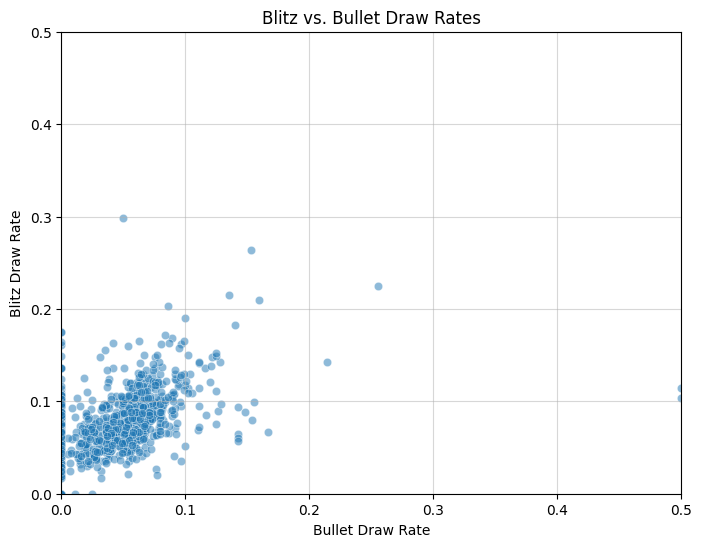

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
try:
    df_clean = pd.read_csv("chess_com_draw_rate_results.csv")
except:
    exit()
plt.figure(figsize=(8, 6))
sns.scatterplot(x='draw_rate_bullet', y='draw_rate_blitz', data=df_clean, alpha=0.5)
plt.title('Blitz vs. Bullet Draw Rates')
plt.xlabel('Bullet Draw Rate')
plt.ylabel('Blitz Draw Rate')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.grid(True, alpha=0.5)
plt.show()

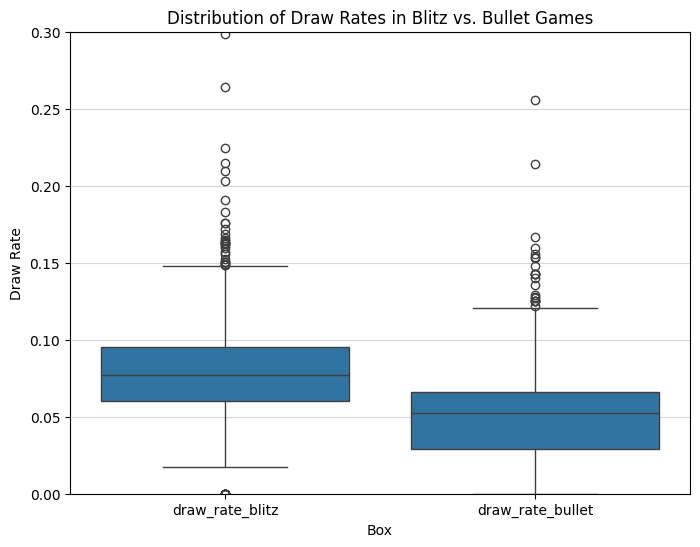

In [ ]:

plot_data = df_clean[['draw_rate_blitz', 'draw_rate_bullet']].melt(var_name='Box', value_name='Draw Rate')
plt.figure(figsize=(8, 6))
sns.boxplot(x='Box', y='Draw Rate', data=plot_data)
plt.title('Distribution of Draw Rates in Blitz vs. Bullet Games')
plt.ylabel('Draw Rate')
plt.ylim(0,0.3)
plt.grid(axis='y', alpha=0.5)
plt.show()

H₀ (Null): The effect of playing White vs Black on win probability does not vary by time control.
H₁ (Alternative): The advantage of playing White differs depending on the time_class (e.g., bigger in rapid/classical, smaller in blitz/bullet).


Fetched 834 games so far for fabianocaruana
Fetched 2906 games so far for magnuscarlsen
Cleaned dataset shape: (2906, 5)
         username  color      result time_class  win
0    NexoKnight11      1    resigned      blitz    0
1  FabianoCaruana      0         win      blitz    1
2  FabianoCaruana      1         win      blitz    1
3             GAO      0  checkmated      blitz    0
4      thebeaglez      1     timeout      blitz    0

Win rates and White advantage by time control:
color              0         1  white_advantage
time_class                                     
blitz       0.436800  0.460000         0.023200
bullet      0.466667  0.488889         0.022222
rapid       0.250000  0.367647         0.117647


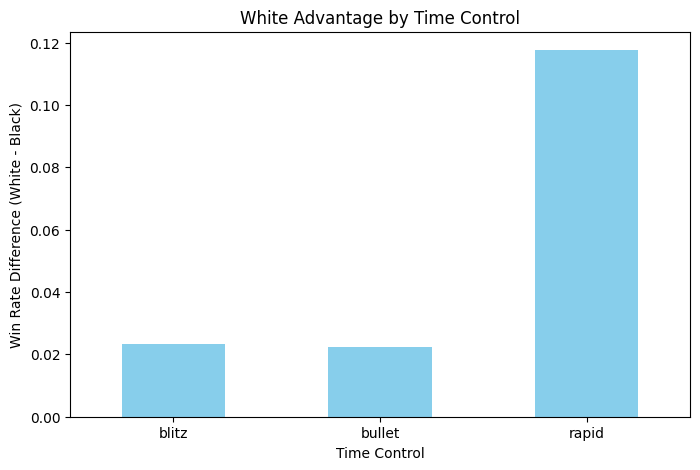


Number of games per color by time control:
color          0     1
time_class            
blitz       1250  1250
bullet       135   135
rapid         68    68


In [ ]:

import requests              # For fetching data from Chess.com API
import pandas as pd          # For DataFrame operations
import numpy as np           # For numerical operations
import matplotlib.pyplot as plt  # For plotting results


HEADERS = {"User-Agent": "MyChessApp/1.0"}  # Required by Chess.com API

# ------------------------------
#  Define Functions to Fetch Player Games
# ------------------------------
def get_player_archives(username):
    """
    Returns a list of monthly archive URLs for a given player.
    Each archive contains all games in that month.
    """
    url = f"https://api.chess.com/pub/player/{username}/games/archives"
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    return resp.json().get("archives", [])

def fetch_games_from_archive(archive_url):
    """
    Fetches all games from a single archive URL.
    Returns a list of dicts with 'username', 'color', 'result', 'time_class'.
    """
    resp = requests.get(archive_url, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    games = data.get("games", [])

    game_list = []
    for g in games:
        if "white" in g and "black" in g and "time_class" in g:
            for color in ["white", "black"]:
                game_info = g[color]
                game_list.append({
                    "username": game_info.get("username"),
                    "color": color,
                    "result": game_info.get("result"),
                    "time_class": g.get("time_class")
                })
    return game_list

# ------------------------------
# Fetch Games for Multiple Players
# ------------------------------
usernames = ["fabianocaruana", "magnuscarlsen"]  # Add more usernames as needed
all_games = []

for username in usernames:
    try:
        archives = get_player_archives(username)
        # Fetch last 6 months for each player
        for archive_url in archives[-6:]:
            games = fetch_games_from_archive(archive_url)
            all_games.extend(games)
        print(f"Fetched {len(all_games)} games so far for {username}")
    except Exception as e:
        print(f"Failed for {username}: {e}")

# ------------------------------
# Build DataFrame and Clean Data
# ------------------------------
df = pd.DataFrame(all_games)

# Encode results: 1 = win, 0 = loss/resigned/etc.
df["win"] = np.where(df["result"] == "win", 1, 0)

# Encode color: 1 = white, 0 = black
df["color"] = np.where(df["color"] == "white", 1, 0)

# Remove games with missing time_class
df = df.dropna(subset=["time_class"])

print("Cleaned dataset shape:", df.shape)
print(df.head())

# ------------------------------
# Filter Time Controls with Enough Games
# ------------------------------
min_games = 50
valid_time_controls = df.groupby('time_class')['win'].count()[lambda x: x >= min_games].index
df_filtered = df[df['time_class'].isin(valid_time_controls)]

# ------------------------------
# Compute Win Rates and White Advantage
# ------------------------------
win_rates = df_filtered.groupby(["time_class", "color"])["win"].mean().unstack()
win_rates = win_rates.reindex(columns=[0,1])  # Ensure 0=black, 1=white
win_rates["white_advantage"] = win_rates[1] - win_rates[0]

print("\nWin rates and White advantage by time control:")
print(win_rates)

# ------------------------------
# Plot White Advantage by Time Control
# ------------------------------
plt.figure(figsize=(8,5))
win_rates["white_advantage"].plot(kind="bar", color="skyblue")
plt.title("White Advantage by Time Control")
plt.ylabel("Win Rate Difference (White - Black)")
plt.xlabel("Time Control")
plt.xticks(rotation=0)
plt.show()

# ------------------------------
# Quick Check: Number of Games by Color and Time Control
# ------------------------------
color_counts = df_filtered.groupby(['time_class', 'color']).size().unstack(fill_value=0)
print("\nNumber of games per color by time control:")
print(color_counts)


Added 50 usernames from leaderboard 'live_blitz'.
Added 50 usernames from leaderboard 'live_bullet'.
Added 1660 usernames with title 'GM'.
Added 2514 usernames with title 'IM'.
Added 4342 usernames with title 'FM'.
Total usernames used: 200
Processed 20 users, total games so far: 6320
Processed 40 users, total games so far: 17536
Processed 60 users, total games so far: 35096
Processed 80 users, total games so far: 44864
Processed 100 users, total games so far: 55274
Processed 120 users, total games so far: 75402
Processed 140 users, total games so far: 86242
Processed 160 users, total games so far: 96568
Processed 180 users, total games so far: 105120
Processed 200 users, total games so far: 111830
Cleaned dataset shape: (111830, 5)
     username  color      result time_class  win
0      kylnmd      1         win      blitz    1
1   KetiGrant      0    resigned      blitz    0
2   KetiGrant      1  checkmated      blitz    0
3     Maaikee      0         win      blitz    1
4  DianaMirz

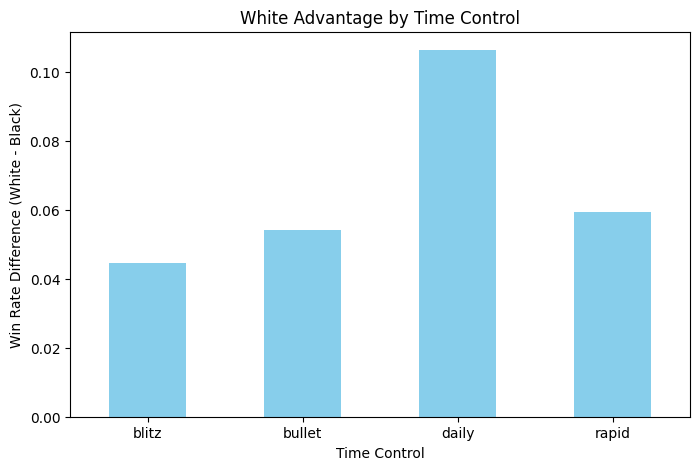


White vs Black counts per time control:
color           0      1
time_class              
blitz       36888  36888
bullet      17918  17918
daily         235    235
rapid         874    874

T-test results for White vs Black by time control:
blitz: t-statistic = 12.177, p-value = 0.0000
bullet: t-statistic = 10.300, p-value = 0.0000
daily: t-statistic = 2.369, p-value = 0.0182
rapid: t-statistic = 2.512, p-value = 0.0121


In [ ]:


import requests          # For API requests
import pandas as pd      # For DataFrames
import numpy as np       # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from scipy.stats import ttest_ind  # For t-tests


HEADERS = {"User-Agent": "MyChessApp/1.0"}


def get_leaderboard_users(leaderboard_key):
    """Fetch usernames from Chess.com leaderboard (e.g., live_blitz)."""
    url = "https://api.chess.com/pub/leaderboards"
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    return [p['username'] for p in data.get(leaderboard_key, [])]

def get_titled_players(title):
    """Fetch usernames of titled players (GM, IM, FM)."""
    url = f"https://api.chess.com/pub/titled/{title}"
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    return data.get('players', [])

def get_player_archives(username):
    """Get monthly archive URLs for a player."""
    url = f"https://api.chess.com/pub/player/{username}/games/archives"
    resp = requests.get(url, headers=HEADERS)
    resp.raise_for_status()
    return resp.json().get("archives", [])

def fetch_games_from_archive(archive_url):
    """Fetch games from a single archive, returning a flat list of dicts."""
    resp = requests.get(archive_url, headers=HEADERS)
    resp.raise_for_status()
    data = resp.json()
    games = data.get("games", [])

    game_list = []
    for g in games:
        if "white" in g and "black" in g and "time_class" in g:
            for color in ["white", "black"]:
                game_info = g[color]
                game_list.append({
                    "username": game_info.get("username"),
                    "color": color,
                    "result": game_info.get("result"),
                    "time_class": g.get("time_class")
                })
    return game_list

# ===============================================
# Collect Usernames
# ===============================================
usernames = set()

# Leaderboard users
leaderboard_keys = ['live_blitz', 'live_bullet']
for key in leaderboard_keys:
    try:
        lb_users = get_leaderboard_users(key)
        usernames.update(lb_users)
        print(f"Added {len(lb_users)} usernames from leaderboard '{key}'.")
    except Exception as e:
        print(f"Failed to get leaderboard '{key}': {e}")

# Titled players
titles = ['GM', 'IM', 'FM']
for title in titles:
    try:
        titled_users = get_titled_players(title)
        usernames.update(titled_users)
        print(f"Added {len(titled_users)} usernames with title '{title}'.")
    except Exception as e:
        print(f"Failed to get titled players '{title}': {e}")

# Limit for speed
usernames = list(usernames)[:200]
print(f"Total usernames used: {len(usernames)}")

# ===============================================
# Fetch Games (last 3 months per player)
# ===============================================
all_games = []
for i, username in enumerate(usernames):
    try:
        archives = get_player_archives(username)
        for archive_url in archives[-3:]:
            games = fetch_games_from_archive(archive_url)
            all_games.extend(games)
        if (i+1) % 20 == 0:
            print(f"Processed {i+1} users, total games so far: {len(all_games)}")
    except Exception as e:
        print(f"Failed for {username}: {e}")

# ===============================================
#  Build DataFrame and Clean Data
# ===============================================
df = pd.DataFrame(all_games)

# Drop rows missing time_class
df = df.dropna(subset=["time_class"])

# Encode wins: 1=win, 0=loss/etc.
df["win"] = np.where(df["result"] == "win", 1, 0)

# Encode color: 1=white, 0=black
df["color"] = np.where(df["color"] == "white", 1, 0)

print("Cleaned dataset shape:", df.shape)
print(df.head())

# ===============================================
# Compute Win Rates & White Advantage
# ===============================================
# Optional: remove time controls with <50 games
min_games = 50
valid_time_controls = df['time_class'].value_counts()[lambda x: x >= min_games].index
df_filtered = df[df['time_class'].isin(valid_time_controls)]

win_rates = df_filtered.groupby(["time_class", "color"])["win"].mean().unstack()
win_rates = win_rates.reindex(columns=[0,1])
win_rates["white_advantage"] = win_rates[1] - win_rates[0]

print("\nWin rates and White advantage by time control:")
print(win_rates)

# ===============================================
# Plot White Advantage
# ===============================================
plt.figure(figsize=(8,5))
win_rates["white_advantage"].plot(kind="bar", color="skyblue")
plt.title("White Advantage by Time Control")
plt.ylabel("Win Rate Difference (White - Black)")
plt.xlabel("Time Control")
plt.xticks(rotation=0)
plt.show()

# ===============================================
# Check number of games per color
# ===============================================
color_counts = df_filtered.groupby(['time_class', 'color']).size().unstack(fill_value=0)
print("\nWhite vs Black counts per time control:")
print(color_counts)

# ===============================================
# T-Test: White vs Black Win Rate
# ===============================================
print("\nT-test results for White vs Black by time control:")
for tc in df_filtered['time_class'].unique():
    data_tc = df_filtered[df_filtered['time_class'] == tc]
    white_wins = data_tc[data_tc['color'] == 1]['win']
    black_wins = data_tc[data_tc['color'] == 0]['win']

    # Only perform t-test if both colors have at least 2 games
    if len(white_wins) > 1 and len(black_wins) > 1:
        t_stat, p_val = ttest_ind(white_wins, black_wins, equal_var=False)
        print(f"{tc}: t-statistic = {t_stat:.3f}, p-value = {p_val:.4f}")
    else:
        print(f"{tc}: Not enough games for a t-test.")


In [ ]:
#FOR CLEANED VS ORIGINAL DATATSET

# ------------------------------
# Show original dataset
# ------------------------------
print("Original dataset:")
print(df.head())   # Shows the first 5 rows

# ------------------------------
# Clean the data
# ------------------------------
df["win"] = np.where(df["result"] == "win", 1, 0)
df["color"] = np.where(df["color"] == "white", 1, 0)
df = df.dropna(subset=["time_class"])

# ------------------------------
# Show cleaned dataset
# ------------------------------
print("\nCleaned dataset:")
print(df.head())   # Shows first 5 rows after cleaning


Original dataset:
     username  color      result time_class  win
0      kylnmd      1         win      blitz    1
1   KetiGrant      0    resigned      blitz    0
2   KetiGrant      1  checkmated      blitz    0
3     Maaikee      0         win      blitz    1
4  DianaMirza      1         win      blitz    1

Cleaned dataset:
     username  color      result time_class  win
0      kylnmd      0         win      blitz    1
1   KetiGrant      0    resigned      blitz    0
2   KetiGrant      0  checkmated      blitz    0
3     Maaikee      0         win      blitz    1
4  DianaMirza      0         win      blitz    1


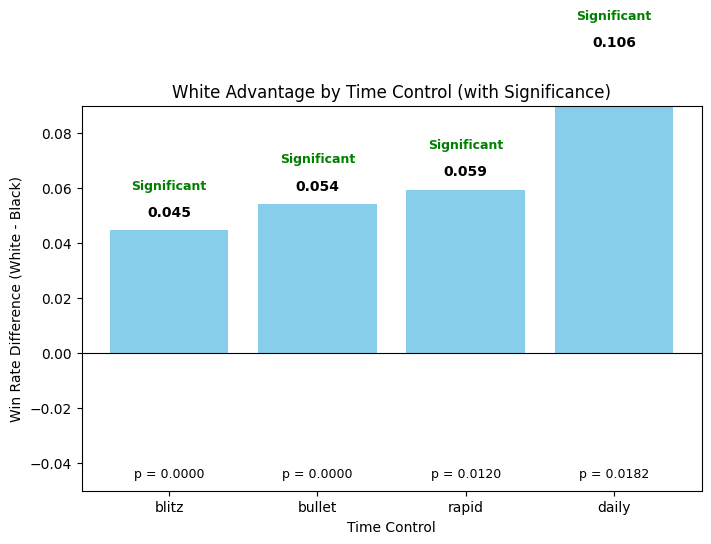

In [ ]:
import matplotlib.pyplot as plt

#   white advantage from win_rates["white_advantage"]
white_advantage = {
    "blitz": 0.044649,
    "bullet": 0.054247,
    "rapid": 0.059497,
    "daily": 0.106383
}

#  t-test p-values
p_values = {
    "blitz": 0.0000,
    "bullet": 0.0000,
    "rapid": 0.0120,
    "daily": 0.0182
}

#  Colors: blue if significant (p < 0.05), grey if not
colors = ['skyblue' if p_values[tc] < 0.05 else 'lightgray' for tc in white_advantage.keys()]

plt.figure(figsize=(8,5))
bars = plt.bar(white_advantage.keys(), white_advantage.values(), color=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("White Advantage by Time Control (with Significance)")
plt.ylabel("Win Rate Difference (White - Black)")
plt.xlabel("Time Control")

#  Annotating bars with advantage and p-value
for i, (tc, adv) in enumerate(white_advantage.items()):
    # Show advantage value
    plt.text(i, adv + 0.004 if adv >= 0 else adv - 0.02,
             f"{adv:.3f}", ha='center', va='bottom' if adv >= 0 else 'top', fontweight='bold')

    # Add label if significant
    if p_values[tc] < 0.05:
        plt.text(i, adv + 0.015, "Significant", ha='center', color='green', fontweight='bold', fontsize=9)

    # Show p-value below each bar
    plt.text(i, -0.045, f"p = {p_values[tc]:.4f}", ha='center', fontsize=9, color='black')

plt.ylim(-0.05, 0.09)
plt.show()


In [ ]:
from scipy.stats import norm

# Store results
results = []

for tc in win_rates.index:
    n_white = color_counts.loc[tc, 1]
    n_black = color_counts.loc[tc, 0]
    p_white = win_rates.loc[tc, 1]
    p_black = win_rates.loc[tc, 0]

    # Pooled proportion
    p_pool = (p_white * n_white + p_black * n_black) / (n_white + n_black)

    # Standard error
    se = (p_pool * (1 - p_pool) * (1/n_white + 1/n_black))**0.5

    # z-statistic
    z = (p_white - p_black) / se

    # two-sided p-value
    p_val = 2 * (1 - norm.cdf(abs(z)))

    results.append({
        "time_class": tc,
        "z_statistic": z,
        "p_value": p_val
    })

# Convert to DataFrame
z_test_df = pd.DataFrame(results)
print(z_test_df)


  time_class  z_statistic   p_value
0      blitz    12.165293  0.000000
1     bullet    10.285421  0.000000
2      daily     2.360373  0.018257
3      rapid     2.508931  0.012110


Based on the results of the two-proportion Z-test, there is a statistically significant difference between the win rates of White and Black players across most time controls.
For all formats — blitz, bullet, rapid, and daily — the p-values were below the 0.05 significance level, leading us to reject the null hypothesis (H₀) that both colors have equal chances of winning.

This indicates that playing as White provides a measurable advantage in chess games, regardless of time control.
The magnitude of this advantage may vary slightly between formats, but overall, the data supports the long-standing observation that White tends to win more often than Black.